In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import groupby
import numpy as np
from math import log
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.preprocessing import PolynomialFeatures

In [2]:
raw_data = pd.read_csv('complete_dataset.csv')

Выборка представляет собой ежедневные данные по цене и спросу на электроэнергию в Австралии

In [3]:
raw_data

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,2020-10-02,99585.835,-6.076028,41988.240,26.980251,57597.595,-30.173823,0.625000,12.8,26.0,22.0,0.0,N,N
2102,2020-10-03,92277.025,-1.983471,44133.510,32.438156,48143.515,-33.538025,0.583333,17.4,29.4,19.8,0.0,N,N
2103,2020-10-04,94081.565,25.008614,88580.995,26.571687,5500.570,-0.163066,0.062500,13.5,29.5,8.4,0.0,N,N
2104,2020-10-05,113610.030,36.764701,106587.375,39.616015,7022.655,-6.511550,0.083333,9.1,12.7,7.3,12.8,N,N


Используем данные только за 3 месяца

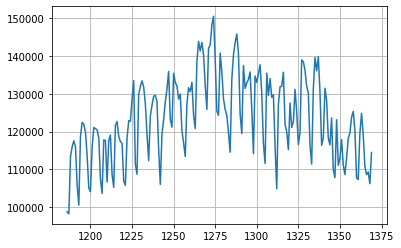

In [21]:
mask = (raw_data['date'] >= '2018-04-01') & (raw_data['date'] <='2018-10-01')
data = raw_data[['date', 'demand']].loc[mask]
plt.plot(data['demand'])
plt.grid()

Проверка на случайность ряда (функция выводит данные сразу для двух проверок в булевом типе)


In [22]:
def median(series):
    return series[len(series) // 2] if len(series) % 2 == 0 else sum(series[len(series) // 2 : len(series) // 2 + 2])/2

def is_series_random(series):
    
    med = median(sorted(series))
    
    n = len(series)
    
    d_series = []
    for i in range(n):
        if series[i] == med:
            d_series.append(0)
        else:
            d_series.append( 1 if series[i] > med else -1)
            
    groups = groupby(d_series)
    result = list(filter(lambda x: x[1] != 0, np.array([[label, sum(1 for _ in group)] for label, group in groups])))
    
    tau_max = max(result, key = lambda x: x[1])
    
    v = len(result)
    
    tau_zero = np.array([5,6,7])[[
        n <= 25,
        n>26 and n <= 153,
        n> 153
    ]]
    
    #print([(v, 1/2*(n+1 - 1.96*(n-1)**.5),(tau_max[1],3.3*log(n-1)))])
    return [(v > 1/2*(n+1 - 1.96*(n-1)**.5) and (tau_max[1] < 3.3*log(n-1))),
            (v > 1/3*(2*n - 1) - 1.96*((16*n - 29) / 90)**.5) and (tau_max < tau_zero[0])]

    
                
    
        

Гипотеза была отвергнута для 5% уровня значимости обоими критериям, следовательно высока вероятность наличия закономерности в ряде

In [23]:
is_series_random(data['demand'].values)

[False, False]

Построим линейноую регркссию для данного ряда

[28.74018806] 120897.30621621621


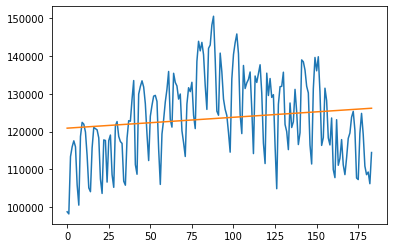

In [24]:
Y = data['demand'].values
X = np.array([*range(len(Y))]).reshape(-1,1)


regressor = LinearRegression()

regressor.fit(X, Y)

a = regressor.coef_
b = regressor.intercept_
print(a,b)

plt.figure()
plt.plot(Y)
plt.plot([a[0]*x + b for x in X])

Из графика, представленного выше, видно, что у данных нелинейная зависимость. Чтобы учесть это, построим полиномы нескольких степеней и оценим визуально наиболее подходящий.

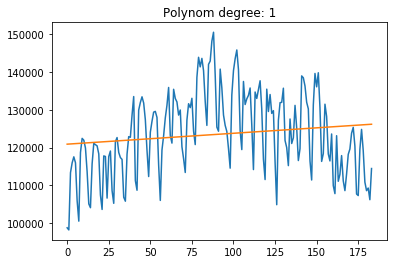

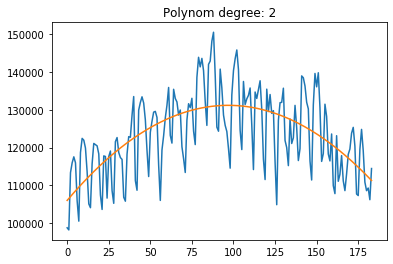

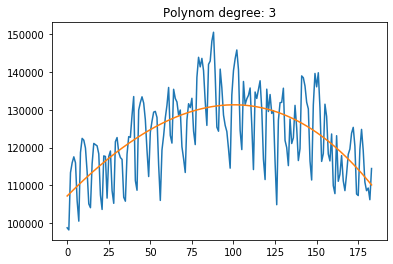

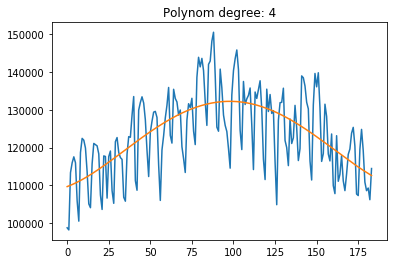

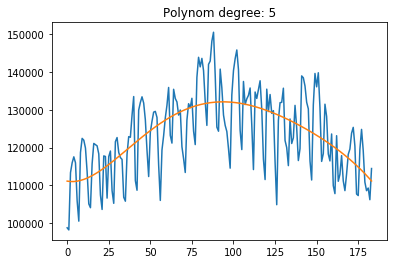

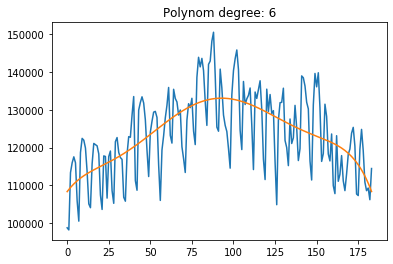

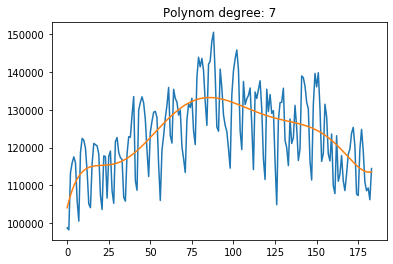

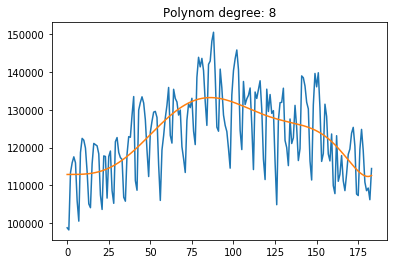

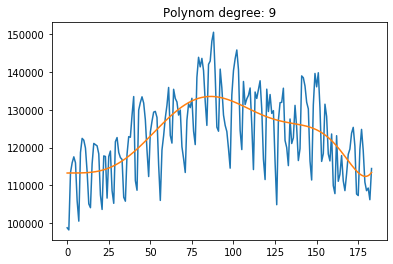

In [25]:
for n in range(1,10):
    Y = data['demand'].values
    X = np.array([*range(len(Y))]).reshape((-1,1))

    X_poly = PolynomialFeatures(degree = n).fit_transform(X)

    regressor = LinearRegression()

    regressor.fit(X_poly, Y)

    plt.figure()
    plt.title('Polynom degree: {}'.format(n))
    plt.plot(Y)
    plt.plot(regressor.predict(X_poly))
    

Из данных графиков, видно, что даже полином второй степени неплохо описывает искомую зависимость.

In [26]:
Y = data['demand'].values
X = np.array([*range(len(Y))]).reshape((-1,1))

X_poly = PolynomialFeatures(degree = 2).fit_transform(X)

regressor = LinearRegression()

regressor.fit(X_poly, Y)

f = regressor.predict(X_poly)

Оценим сезонную составляющую для данного ряда, исходя из эмперического предположения, что в данных относящихся к энергопотреблению имеется недельная сезонность

In [34]:
T = 7
m = len(Y) // T
S = 1/m*np.array([sum([Y[t+j] - f[t+j] for j in range(0,m)]) for t in range(1, T+1)])

Узнаем с какого дня начинаются наши данные

In [28]:
import datetime

day_start = datetime.datetime.strptime(data['date'].iloc[0], '%Y-%m-%d').weekday()

day_end = datetime.datetime.strptime(data['date'].iloc[6], '%Y-%m-%d').weekday()

print(day_start, day_end)

6 5


Это воскресение.<br>
Построим график для 3х недель, видим явную недельную зависимость, спрос на электричество выше по будням, чем по выходным

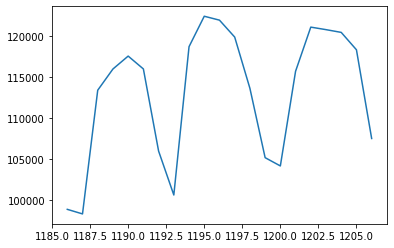

In [40]:
plt.plot(data['demand'].iloc[:21])

Построим оценку сезонности

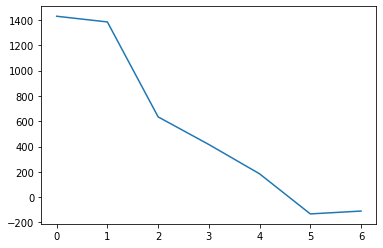

In [35]:
plt.plot(S)

Удаляем тренд из наших данных

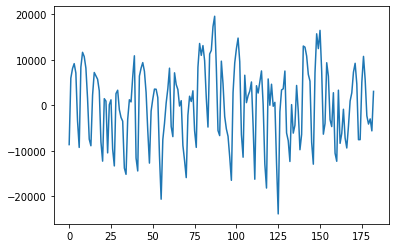

In [312]:
plt.plot(Y - f)

Проведём оценку параметров, не используя аналитические методы. Используем численную минимизацию разности квадратов с помощью стохастического градиентного спуска.

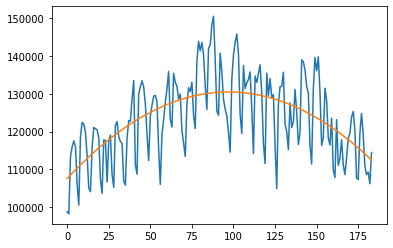

In [43]:
from sklearn.preprocessing import StandardScaler

Y = data['demand'].values
X = np.array([*range(len(Y))]).reshape((-1,1))

X_poly = PolynomialFeatures(degree = 2).fit_transform(X)

scaler = StandardScaler()
scaler.fit(X_poly)

X_poly = scaler.transform(X_poly)

regressor = SGDRegressor(max_iter=1000)

regressor.fit(X_poly, Y)

f = regressor.predict(X_poly)

plt.figure()
plt.plot(Y)
plt.plot(f)

Вычислим остатки для аналитического b численного методов

In [48]:
tail_OLS = Y[:-2] - f[:-2] - np.repeat(S, m)

tail_SGD = Y - f

В обоих случаях остатки являются не случайными

In [49]:
print(is_series_random(tail_OLS), is_series_random(tail_SGD))

[False, False] [False, False]


Построим остатки на диаграмме

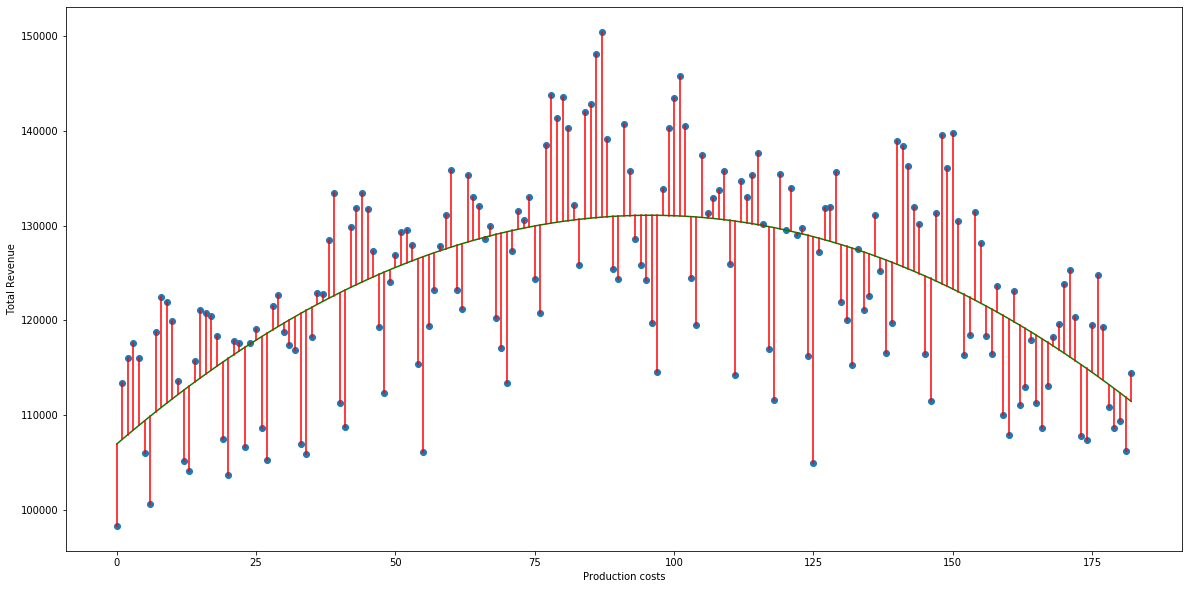

In [343]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.set_xlabel('Production costs')
ax.set_ylabel('Total Revenue')
plt.scatter(X,Y)
plt.plot(X, regressor.predict(X_poly), color = 'g')
for i in range(len(X)):
    true_dots = (X[i], X[i])
    preds = (Y[i], regressor.predict(X_poly)[i])
    plt.plot(true_dots, preds, color = 'r')

Построим прогнозы значений для обоих методов

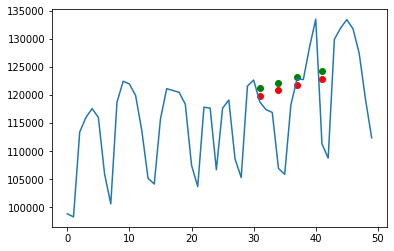

In [51]:
plt.figure()
plt.plot(Y[:50])
plt.scatter([31,34,37,41],  [regressor.predict(X_poly[i].reshape((1,-1))) for i in [31,34,37,41]], c = 'r')

F =  f[:-2] + np.repeat(S, m)

plt.scatter([31,34,37,41],  [F[i] for i in [31,34,37,41]], c = 'g')

Построим сглаживание исходного ряда с помощбю скользящего окна с различными окнами

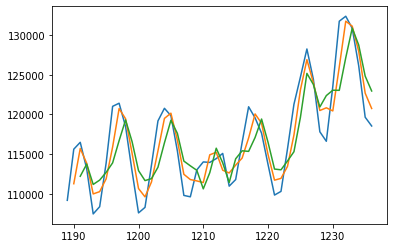

In [339]:
plt.figure()
for num in [3,4,5]:
    plt.plot(data['demand'].rolling(window = num).mean()[:50])

Смоделируем выборку по правилу 14 из методички

In [351]:
eps = np.random.normal(0, 20, 48)
u = eps - 1.2*eps
x = [x for x in range(48)]
y = [180.7 + x*1.4 + u[x] for x in x]


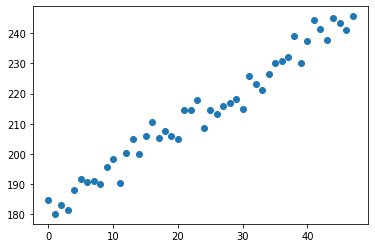

In [352]:
plt.scatter(x,y)

In [353]:
reg = LinearRegression()

reg.fit(np.array(x).reshape((-1,1)),y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [354]:
residuals = y - reg.predict(np.array(x).reshape((-1,1)))

In [355]:
from statsmodels.stats.stattools import durbin_watson

Оценка коэффициента Дарбина-Уотса и коэффициента автокорреляции показывают остутствие автокорреляции ( Дарбин-Уотс близок к 2, а коэф. автокорреляции к 0)

In [356]:
# near 2 --> no correlation
durbin_watson(residuals) 

1.8952695396147263

In [357]:
pd.Series(residuals).autocorr(lag = 1)

0.04643531017730163